<a href="https://colab.research.google.com/github/ajaysinha1804/nailDiseasesAnalysis/blob/main/VGG16_final_on_new_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,re,h5py
import time
from tensorflow.keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Activation, Flatten,Conv2D,MaxPooling2D, Dropout,BatchNormalization,ZeroPadding2D,Concatenate,Input
from keras.models import Model
from keras.callbacks import CSVLogger, ReduceLROnPlateau
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define Paths

In [ ]:
PATH = "/content/drive/MyDrive/datasetnew/"
METRICS_PATH="/content/drive/MyDrive/Metrics"
MODEL_NAME="VGG16"
print("PWD", PATH)

PWD /content/drive/MyDrive/datasetnew/


# Define Metrics

In [ ]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [ ]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_negatives / (true_negatives+false_positives + K.epsilon())

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Read Images from drive

In [ ]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [ ]:
data_path = PATH
data_dir_list = sorted_alphanumeric(os.listdir(data_path))
print(data_dir_list)

['Acral Lentiginous Melanoma', 'Bluish Nail', 'Clubbing', 'Healthy Nail', 'Koilonychia', 'Nail Pitting', 'Onychogryphosis', 'onycholysis']


In [ ]:

img_data_list = []

for dataset in data_dir_list:
    img_list = sorted_alphanumeric(os.listdir(data_path + '/' + dataset))
    print('Loaded the images of dataset-' + '{}\n'.format(dataset))
    for img in img_list:
        img_path = data_path + '/' + dataset + '/' + img
        img = image.load_img(img_path, target_size=(32,32))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        x = x/255
        img_data_list.append(x)


Loaded the images of dataset-Acral Lentiginous Melanoma

Loaded the images of dataset-Bluish Nail

Loaded the images of dataset-Clubbing

Loaded the images of dataset-Healthy Nail

Loaded the images of dataset-Koilonychia

Loaded the images of dataset-Nail Pitting

Loaded the images of dataset-Onychogryphosis

Loaded the images of dataset-onycholysis



In [ ]:
img_data = np.array(img_data_list)
print(img_data.shape)
img_data = np.rollaxis(img_data, 1, 0)
print(img_data.shape)
img_data = img_data[0]
print(img_data.shape)


(8033, 1, 32, 32, 3)
(1, 8033, 32, 32, 3)
(8033, 32, 32, 3)


# Train and Test Data

In [ ]:
num_classes = 8
num_of_samples = img_data.shape[0]
print("sample", num_of_samples)
labels = np.ones((num_of_samples,), dtype='int64')
labels[0:859] = 0
labels[859:2191] = 1
labels[2191:3380] = 2
labels[3380:4222] = 3
labels[4222:5121] = 4
labels[5121:5865] = 5
labels[5865:7269] = 6
labels[7269:8033] = 7

names = ['Acral Lentiginous Melanoma', 'Bluish Nail', 'Clubbing', 'Healthy Nail', 'Koilonychia', 'Nail Pitting', 'Onychogryphosis', 'onycholysis']

sample 8033


In [ ]:
from sklearn.utils import shuffle

In [ ]:
Y = to_categorical(labels, num_classes)
x, y = shuffle(img_data, Y, random_state=2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


# Model Architecture

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(8))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 32, 32, 64)        0         
                                                        

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy',f1,specificity,sensitivity])

In [ ]:
print((METRICS_PATH+MODEL_NAME+".csv"))

/content/drive/MyDrive/MetricsVGG16.csv


In [ ]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+".csv")
model_chekpoint = ModelCheckpoint("vgg16.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)


# Model Training

### With Augumentation

In [ ]:
batch_size = 16
data_augmentation = True
epochs = 100

In [ ]:
import time
start_time = time.time()

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True, callbacks=[lr_reducer,csv_logger])
else:
    print('Using real-time data augmentation.')
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_test, y_test), callbacks=[lr_reducer, csv_logger,model_chekpoint])

Using real-time data augmentation.
Epoch 1/100
  1/402 [..............................] - ETA: 24s - loss: 0.0928 - accuracy: 0.9375 - f1: 0.9375 - specificity: 0.9911 - sensitivity: 0.9375

<ipython-input-31-7af227231165>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train,


400/402 [============================>.] - ETA: 0s - loss: 0.0966 - accuracy: 0.9687 - f1: 0.9689 - specificity: 0.9962 - sensitivity: 0.9648
Epoch 1: val_loss improved from 0.13253 to 0.13017, saving model to vgg16.hdf5
402/402 [==============================] - 10s 24ms/step - loss: 0.0964 - accuracy: 0.9689 - f1: 0.9690 - specificity: 0.9962 - sensitivity: 0.9650 - val_loss: 0.1302 - val_accuracy: 0.9670 - val_f1: 0.9678 - val_specificity: 0.9956 - val_sensitivity: 0.9663 - lr: 1.0000e-06
Epoch 2/100
400/402 [============================>.] - ETA: 0s - loss: 0.0919 - accuracy: 0.9720 - f1: 0.9710 - specificity: 0.9965 - sensitivity: 0.9667
Epoch 2: val_loss did not improve from 0.13017
402/402 [==============================] - 12s 30ms/step - loss: 0.0930 - accuracy: 0.9715 - f1: 0.9705 - specificity: 0.9965 - sensitivity: 0.9663 - val_loss: 0.1326 - val_accuracy: 0.9670 - val_f1: 0.9672 - val_specificity: 0.9954 - val_sensitivity: 0.9663 - lr: 1.0000e-06
Epoch 3/100
400/402 [=====

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print("Max Test accuracy", max(history.history['val_accuracy']))

51/51 [==============================] - 0s 8ms/step - loss: 0.1303 - accuracy: 0.9676 - f1: 0.9681 - specificity: 0.9956 - sensitivity: 0.9669
dict_keys(['loss', 'accuracy', 'f1', 'specificity', 'sensitivity', 'val_loss', 'val_accuracy', 'val_f1', 'val_specificity', 'val_sensitivity', 'lr'])
dict_values([[0.09635133296251297, 0.09295408427715302, 0.09480246156454086, 0.100840725004673, 0.09362398087978363, 0.08854406327009201, 0.10206849873065948, 0.0932094156742096, 0.09590240567922592, 0.08887095749378204, 0.09594951570034027, 0.10202603787183762, 0.10640425235033035, 0.09150964766740799, 0.09895479679107666, 0.08990723639726639, 0.10182084888219833, 0.10148152709007263, 0.09750911593437195, 0.0991787537932396, 0.10308415442705154, 0.10182233899831772, 0.09051327407360077, 0.1080302819609642, 0.10294514894485474, 0.09918275475502014, 0.10034289211034775, 0.10511087626218796, 0.09673894941806793, 0.09459048509597778, 0.09491419792175293, 0.10062575340270996, 0.09503275156021118, 0.09

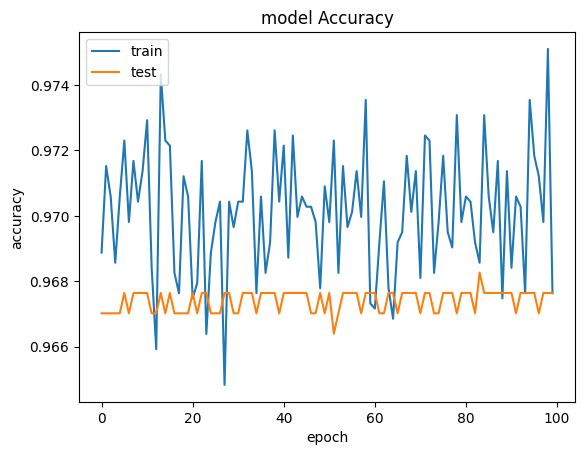

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()

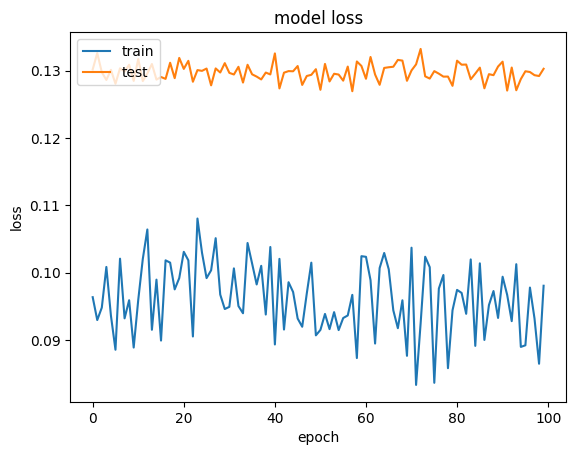

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()


### Without Augumentation

In [ ]:
MODEL_NAME="VGG16_waug"

In [ ]:
batch_size = 16
data_augmentation = False
epochs = 100

In [ ]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+".csv")
model_chekpoint = ModelCheckpoint("VGG16_waug",monitor = 'val_loss',verbose = 1,save_best_only=True)


In [ ]:
import time
start_time = time.time()

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True, callbacks=[lr_reducer,csv_logger,model_chekpoint])
else:
    print('Using real-time data augmentation.')
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_test, y_test), callbacks=[lr_reducer, csv_logger])

Not using data augmentation.
Epoch 1/100
401/402 [============================>.] - ETA: 0s - loss: 0.0616 - accuracy: 0.9825 - f1: 0.9819 - specificity: 0.9977 - sensitivity: 0.9802
Epoch 1: val_loss improved from inf to 0.11671, saving model to VGG16_waug
402/402 [==============================] - 16s 39ms/step - loss: 0.0618 - accuracy: 0.9824 - f1: 0.9817 - specificity: 0.9977 - sensitivity: 0.9800 - val_loss: 0.1167 - val_accuracy: 0.9726 - val_f1: 0.9736 - val_specificity: 0.9966 - val_sensitivity: 0.9709 - lr: 5.0000e-07
Epoch 2/100
402/402 [==============================] - ETA: 0s - loss: 0.0634 - accuracy: 0.9807 - f1: 0.9799 - specificity: 0.9974 - sensitivity: 0.9780
Epoch 2: val_loss improved from 0.11671 to 0.11613, saving model to VGG16_waug
402/402 [==============================] - 16s 39ms/step - loss: 0.0634 - accuracy: 0.9807 - f1: 0.9799 - specificity: 0.9974 - sensitivity: 0.9780 - val_loss: 0.1161 - val_accuracy: 0.9726 - val_f1: 0.9730 - val_specificity: 0.9965 

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

print("Max Test accuracy", max(history.history['val_accuracy']))

51/51 [==============================] - 0s 9ms/step - loss: 0.1130 - accuracy: 0.9726 - f1: 0.9738 - specificity: 0.9967 - sensitivity: 0.9712
dict_keys(['loss', 'accuracy', 'f1', 'specificity', 'sensitivity', 'val_loss', 'val_accuracy', 'val_f1', 'val_specificity', 'val_sensitivity', 'lr'])
dict_values([[0.06182652711868286, 0.0633620023727417, 0.0651116743683815, 0.06444183737039566, 0.06631012260913849, 0.051348429173231125, 0.06805700808763504, 0.06663563847541809, 0.06191449612379074, 0.06289990246295929, 0.061388082802295685, 0.06587769836187363, 0.06516359001398087, 0.05735922232270241, 0.07237643748521805, 0.0625649020075798, 0.06651516258716583, 0.06757733970880508, 0.0658821240067482, 0.06121969595551491, 0.06317318975925446, 0.061767514795064926, 0.06365964561700821, 0.07096292078495026, 0.05753868818283081, 0.06106991320848465, 0.06272923946380615, 0.06003094092011452, 0.06434373557567596, 0.06659290939569473, 0.06096307933330536, 0.06312806159257889, 0.06027422472834587, 

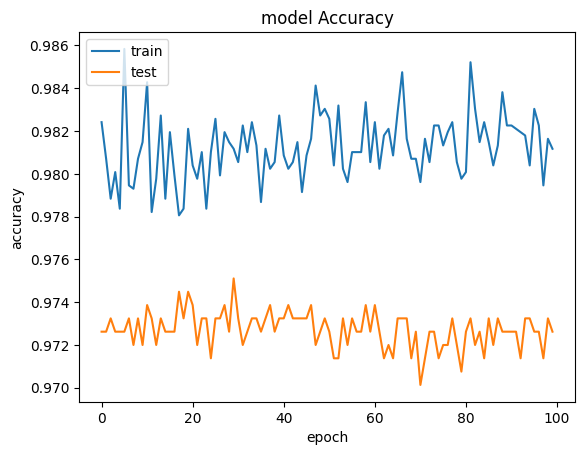

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()

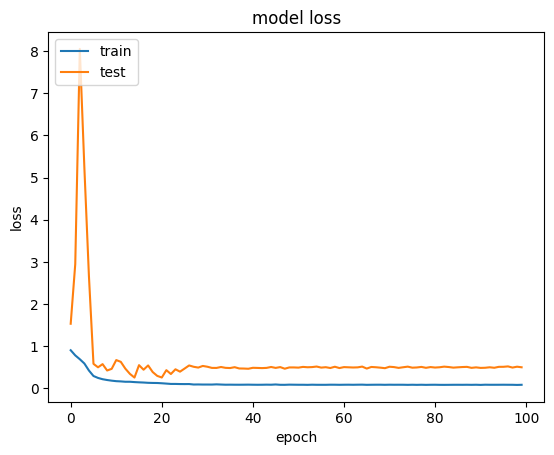

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()


In [ ]:
model.save("vggfinal.hdf5")

In [ ]:
img_path = '/content/drive/MyDrive/datasetnew/Bluish Nail/15_PNG_jpg.rf.c8ca108803789954d3f30b3b35358995.jpg'  # Change this to the path of your image
img = image.load_img(img_path, target_size=(32, 32))  # Resize the image to match VGG16 input shape
img_array = image.img_to_array(img)  # Convert image to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension



# Make predictions
predictions = model.predict(img_array)

# Get the predicted class label
predicted_class = np.argmax(predictions, axis=1)

print('Predicted class:', predicted_class)



1/1 [==============================] - 0s 19ms/step
Predicted class: [6]


In [ ]:
img_path = '/content/Screenshot 2024-02-05 192003.png'  # Change this to the path of your image
img = image.load_img(img_path, target_size=(32,32))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x = x/255
# Make predictions
predictions = model.predict(x)

# Get the predicted class label
predicted_class = np.argmax(predictions, axis=1)

print('Predicted class:', predicted_class)

1/1 [==============================] - 0s 33ms/step
Predicted class: [7]
